In [6]:
import dataclasses
import glob
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as onp
from skimage import measure

import invrs_opt

In [7]:
from totypes import types
from importlib import reload
from invrs_gym.challenges.sorter import polarization_challenge, common
from invrs_gym.utils import initializers
reload(polarization_challenge)
reload(common)

def rescale_density(density, scale):
    rescaled_array = density.array - density.lower_bound
    rescaled_array /= (density.upper_bound - density.lower_bound) / scale
    return dataclasses.replace(
        density,
        array=rescaled_array,
        lower_bound=0,
        upper_bound=(density.upper_bound - density.lower_bound) * scale,
    )

def density_initializer(key, seed_density):
    density = initializers.noisy_density_initializer(
        key=key,
        seed_density=seed_density,
        relative_mean=0.5,
        relative_noise_amplitude=0.1,
    )
    return rescale_density(density, 0.001)

# Select the challenge to be solved.
challenge = polarization_challenge.polarization_sorter(
    density_initializer=density_initializer,
    minimum_width=8,
    minimum_spacing=8,
)


def transform_density(density: types.Density2DArray, beta: float) -> types.Density2DArray:
    transformed = types.symmetrize_density(density)
    with jax.ensure_compile_time_eval():
        transformed = transform.density_gaussian_filter_and_tanh(transformed, beta=beta)
    # Scale to ensure that the full valid range of the density array is reachable.
    mid_value = (density.lower_bound + density.upper_bound) / 2
    transformed = tree_util.tree_map(
        lambda array: mid_value + (array - mid_value) / jnp.tanh(beta), transformed
    )
    return transform.apply_fixed_pixels(transformed)


# Define the loss function; in this case we simply use the default challenge
# loss. Note that the loss function can return auxilliary quantities.
def loss_fn(params):
    response, aux = challenge.component.response(params)
    loss = challenge.loss(response)
    return loss, (response, aux)


# Get the initial parameters, and initialize the optimizer.
seed = 2
params = challenge.component.init(jax.random.PRNGKey(seed))
opt = invrs_opt.density_lbfgsb(beta=2)
# opt = invrs_opt.lbfgsb()
state = opt.init(params)
params = opt.params(state)

# _ = challenge.component.response(params)

# The metagrating challenge can be jit-compiled.
# value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn, has_aux=True))
value_and_grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
# (value, (response, aux)), grad = value_and_grad_fn(params)

# Carry out optimization for a fixed number of steps.
loss_values = []
distance_values = []
for i in range(150):
    t0 = time.time()
    params = opt.params(state)
    (value, (response, aux)), grad = value_and_grad_fn(params)
    t1 = time.time()
    state = opt.update(grad=grad, value=value, params=params, state=state)

    print(
        f"{i:03} ({t1 - t0:.2f}/{time.time() - t1:.2f}s): loss={value:.3f}, "
        f"power={response.reflection + jnp.sum(response.quadrant_transmission, axis=-1)}"
    )
    # for p in aux:
    #     print(p)
    loss_values.append(value)

000 (53.06/0.30s): loss=0.952, power=[0.9814789  0.9830941  0.98099357 0.9821456 ]
001 (35.17/0.05s): loss=0.803, power=[1.0585213 1.0876892 1.0856317 1.0707858]
002 (37.59/0.39s): loss=0.747, power=[1.0771228 1.0361519 1.0754797 1.0305408]
003 (56.44/0.35s): loss=0.804, power=[1.0679795 1.07031   1.0379411 1.0755358]
004 (47.26/0.12s): loss=0.994, power=[1.0987885 1.1163751 1.1061035 1.0788128]
005 (41.55/0.18s): loss=0.724, power=[1.0426364 1.0393405 1.0487345 1.0353804]
006 (46.51/0.18s): loss=0.698, power=[1.044296  1.0268582 1.047323  1.0297412]
007 (27.24/0.37s): loss=0.684, power=[1.0820029 1.0503981 1.0431168 1.01683  ]
008 (42.84/0.07s): loss=0.593, power=[1.0353112 1.0278314 1.0233927 1.0200742]
009 (58.76/0.20s): loss=0.597, power=[1.0176882 1.0166383 1.0317895 1.0372928]
010 (46.71/0.34s): loss=0.586, power=[1.0414394 1.0248262 1.0270491 1.0169681]
011 (64.77/0.24s): loss=0.540, power=[1.0085971 1.0227263 1.0093226 1.0129821]
012 (51.94/0.29s): loss=0.505, power=[1.0099463 

Exception ignored in: <function _xla_gc_callback at 0x7f857c93f0a0>
Traceback (most recent call last):
  File "/home/mfschubert/miniforge3/envs/invrs/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7f857c93f0a0>
Traceback (most recent call last):
  File "/home/mfschubert/miniforge3/envs/invrs/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
seed = 2
initial_params = challenge.component.init(jax.random.PRNGKey(seed))

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.imshow(common._density_array(initial_params["density_metasurface"]))
plt.colorbar()
plt.subplot(122)
plt.imshow(common._density_array(params["density_metasurface"]))
plt.colorbar()
print(f"        cap initial={initial_params['thickness_cap'].array}, final={params['thickness_cap'].array}")
print(f"metasurface initial={initial_params['thickness_metasurface'].array}, final={params['thickness_metasurface'].array}")
print(f"     spacer initial={initial_params['thickness_spacer'].array}, final={params['thickness_spacer'].array}")


In [ ]:
plt.plot(loss_values)
print(response.quadrant_transmission)
print(response.quadrant_target_transmission)
print(response.reflection)

jnp.sum(response.quadrant_transmission, axis=0)

# jnp.sum(response.transmission, axis=0)

In [ ]:
sz = aux["poynting_flux_z"]

plt.figure(figsize=(5, 5))
ax = plt.subplot(221)
ax.imshow(sz[..., 0])
ax.axis(False)
ax = plt.subplot(222)
ax.imshow(sz[..., 1])
ax.axis(False)
ax = plt.subplot(223)
ax.imshow(sz[..., 2])
ax.axis(False)
ax = plt.subplot(224)
ax.imshow(sz[..., 3])
ax.axis(False)
plt.tight_layout()

BoundedArray(array=Array(1.1735129, dtype=float32), lower_bound=0.0, upper_bound=0.3)
BoundedArray(array=Array(4.8387637, dtype=float32), lower_bound=0.05, upper_bound=0.3)
BoundedArray(array=Array(0.50665265, dtype=float32), lower_bound=0.5, upper_bound=1.2)


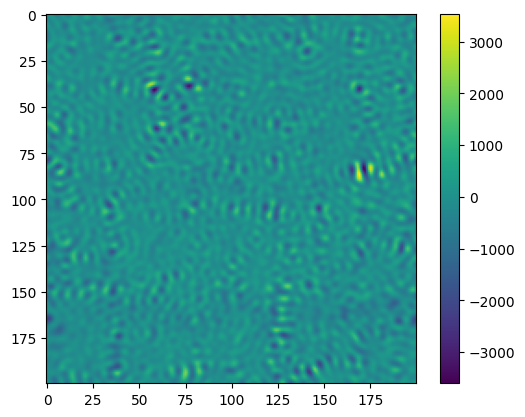

In [52]:
plt.imshow(grad["density_metasurface"].array)
plt.colorbar()
print(grad["thickness_cap"])
print(grad["thickness_metasurface"])
print(grad["thickness_spacer"])

In [53]:
    with jax.ensure_compile_time_eval():
        sz_fwd_N, sz_bwd_N = fields.amplitude_poynting_flux(
            forward_amplitude=fwd_substrate_offset,
            backward_amplitude=bwd_substrate_offset,
            layer_solve_result=layer_solve_results[-1],
        )
        
        sz_fwd_substrate_sum = jnp.sum(jnp.abs(sz_fwd_N), axis=-2)
        sz_bwd_substrate_sum = jnp.sum(jnp.abs(sz_bwd_N), axis=-2)
        printvals = [
            sz_fwd_ambient_sum,
            sz_bwd_ambient_sum,
            sz_fwd_substrate_sum,
            sz_bwd_substrate_sum,
            jnp.mean(sz, axis=(-3, -2)),
            sz_bwd_ambient_sum + sz_fwd_substrate_sum,
            sz_bwd_ambient_sum + jnp.mean(sz, axis=(-3, -2)),
        ]

NameError: name 'fields' is not defined

In [103]:
from jax import tree_util
from totypes import types
from invrs_opt.lbfgsb import transform, lbfgsb

def transform_density(density: types.Density2DArray, beta: float) -> types.Density2DArray:
    transformed = types.symmetrize_density(density)
    transformed = transform.density_gaussian_filter_and_tanh(transformed, beta=beta)
    # Scale to ensure that the full valid range of the density array is reachable.
    mid_value = (density.lower_bound + density.upper_bound) / 2
    transformed = tree_util.tree_map(
        lambda array: mid_value + (array - mid_value) / jnp.tanh(beta), transformed
    )
    return transform.apply_fixed_pixels(transformed)


params, lbfgsb_state_dict = state
lbfgsb_state = lbfgsb.ScipyLbfgsbState(**lbfgsb_state_dict)
latent_params = lbfgsb._to_pytree(lbfgsb_state.x, params)

transform_density(latent_params["density_metasurface"], beta=4)

Density2DArray(array=Array([[6.1960541e-06, 6.2404361e-06, 6.2450090e-06, ..., 5.9067233e-06,
        6.0204711e-06, 6.1197052e-06],
       [5.9867971e-06, 6.0404823e-06, 6.0578741e-06, ..., 5.6974986e-06,
        5.8058195e-06, 5.9052841e-06],
       [5.8268079e-06, 5.8872461e-06, 5.9144804e-06, ..., 5.5411469e-06,
        5.6437184e-06, 5.7421435e-06],
       ...,
       [6.7929009e-06, 6.8064141e-06, 6.7734909e-06, ..., 6.5359432e-06,
        6.6514890e-06, 6.7390661e-06],
       [6.6297735e-06, 6.6529069e-06, 6.6306920e-06, ..., 6.3563402e-06,
        6.4745445e-06, 6.5678810e-06],
       [6.4217807e-06, 6.4555375e-06, 6.4462665e-06, ..., 6.1375058e-06,
        6.2549270e-06, 6.3521825e-06]], dtype=float32), lower_bound=0, upper_bound=1e-05, fixed_solid=None, fixed_void=None, minimum_width=8, minimum_spacing=8, periodic=(True, True), symmetries=())

In [89]:
params

{'density_metasurface': Density2DArray(array=Array([[9.466157e-06, 9.130918e-06, 9.014729e-06, ..., 1.000000e-05,
         9.992997e-06, 1.000000e-05],
        [1.000000e-05, 1.000000e-05, 1.000000e-05, ..., 1.000000e-05,
         1.000000e-05, 1.000000e-05],
        [9.866250e-06, 8.957101e-06, 8.902918e-06, ..., 1.000000e-05,
         1.000000e-05, 1.000000e-05],
        ...,
        [9.961852e-06, 9.961814e-06, 9.968689e-06, ..., 9.995907e-06,
         9.984004e-06, 9.967230e-06],
        [9.970883e-06, 9.880925e-06, 9.200170e-06, ..., 1.000000e-05,
         9.988348e-06, 9.972360e-06],
        [1.000000e-05, 9.880201e-06, 8.942704e-06, ..., 1.000000e-05,
         9.987215e-06, 9.986404e-06]], dtype=float32), lower_bound=0, upper_bound=1e-05, fixed_solid=None, fixed_void=None, minimum_width=8, minimum_spacing=8, periodic=(True, True), symmetries=()),
 'thickness_cap': BoundedArray(array=Array(2.0774539, dtype=float32), lower_bound=0, upper_bound=None),
 'thickness_metasurface': Boun

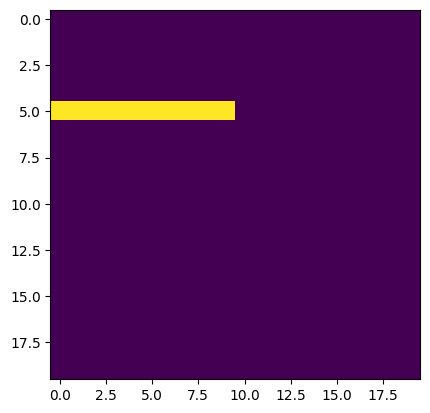

In [284]:
array = onp.zeros((20, 20))
array[5, :10] = 1

plt.imshow(array)